# Attrape moi si tu peux

## Sommaire :

-   [Import du Dataset](#Import-du-dataset)
-   [Fonctions utiles](#Initialisation-des-fonctions-utiles-pour-le-test)
-   [Couche Conv2D](#Conv2D)
-   [Pooling (Max et Average)](#Pooling-(Max-et-Average))
-   [Dropout](#Droupout)
-   [Dense](#Dense)
-   [Tests de modèles](#Tests-de-modèles)


In [1]:
### IMPORTS ###

import matplotlib.pyplot as plt
import cv2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import random
import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Activation, Dropout, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Définition de la seed de tensorflow ###

tf.random.set_seed(2)

In [2]:
### Inspection de la shape d'une image ###

new_image = cv2.imread("data/RAW/train/bear/0001.png")
print(new_image.shape)

(32, 32, 3)


# Import du dataset

On utilise le module ImageDataGenerator pour récupérer les images présentes dans les différents dossier et les transformer en array.

In [3]:
### Déclaration des constantes ###

TRAIN_BASE_DIRECTORY = "./data/test/train"
TEST_BASE_DIRECTORY = "./data/test/test"
TRAIN_IMAGE_SIZE = 32
TRAIN_BATCH_SIZE = 64

In [4]:
image_data_generator = ImageDataGenerator(validation_split=0.5)

train_generator = image_data_generator.flow_from_directory(
    TRAIN_BASE_DIRECTORY,
    target_size=(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=5)

validation_generator = image_data_generator.flow_from_directory(
    TEST_BASE_DIRECTORY,
    target_size=(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=5)

Found 500 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


# Initialisation des fonctions utiles pour le test

In [5]:
### Affichage des graphiques présentant les valeurs de loss et d'accuracy ###

def print_model_history(history):
    '''
        print model training history
    '''
    # list all data in history
    print(history.history.keys())
    plt.figure(figsize=(20,5))

    plt.subplot(1,2,1)
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(1,2,2)
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# print_model_history(training)

In [6]:
### Inspection d'une couche dans le modèle ###

def display_activation(model, col_size, row_size, act_index):

    layer_outputs = [layer.output for layer in model.layers]
    test_image = "./data/test/test/bus/0020.png"

    # Le chargement de l'image doit être augmenté puisque notre modèle prend des lots d'images.
    img = image.load_img(test_image, target_size=(32,32, 3))
    img_arr = image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)

    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(img_arr)

 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*13.5,col_size*2.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index])
            activation_index += 1

# display_activation(model, 8, 4, 4)

In [7]:
### Prédiction de l'objet présent sur une image ###

def predict(model):
    labels_array = os.listdir(TRAIN_BASE_DIRECTORY)

    choix = r"./data/lion.png"

    test_image = image.load_img(choix, target_size = (32, 32))
    plt.imshow(test_image)
    test_image = image.img_to_array(test_image)

    test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(test_image)

    preds = model.predict_classes(test_image)
    prob = model.predict_proba(test_image)

    index = preds[0]
    print(f'Cet objet est un(e) {labels_array[index]}.', 'probs= ', prob[0][index] * 100)

# predict(model)

# Test des différentes couches sur différents modèles

Dans cette partie nous allons tester les différentes couches proposées par Keras et voir leur impact sur les images. Les images utilisées seront toujours les mêmes.

# Conv2D

Cette couche sert à créer une feature map, elle "trouve" les paramètres sur l'image.

In [8]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(32,32,3))) ### La taille du kernel définit la précision de la convolution et influe sur la taille de l'image en sortie

### Fin obligatoire ###
model.add(Flatten())
model.add(Dense(2, activation='softmax')) ### Le paramètre dans cette fonction Dense doit être égal au nombre de catégories recherchées

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

training = model.fit_generator(train_generator, epochs=10, validation_data=validation_generator, shuffle=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 65538     
Total params: 66,434
Trainable params: 66,434
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
8/8 [==============================] - 1s 98ms/step - loss: 359.5824 - accuracy: 0.5200 - val_loss: 21.1473 - val_accuracy: 0.8000
Epoch 2/10
8/8 [==============================] - 0s 47ms/step - loss: 59.0684 - accuracy: 0.7080 - val_loss: 85.8436 - val_accuracy: 0.7000
Epoch 3/10
8/8 [=======

Conv2D avec un kernel à 3


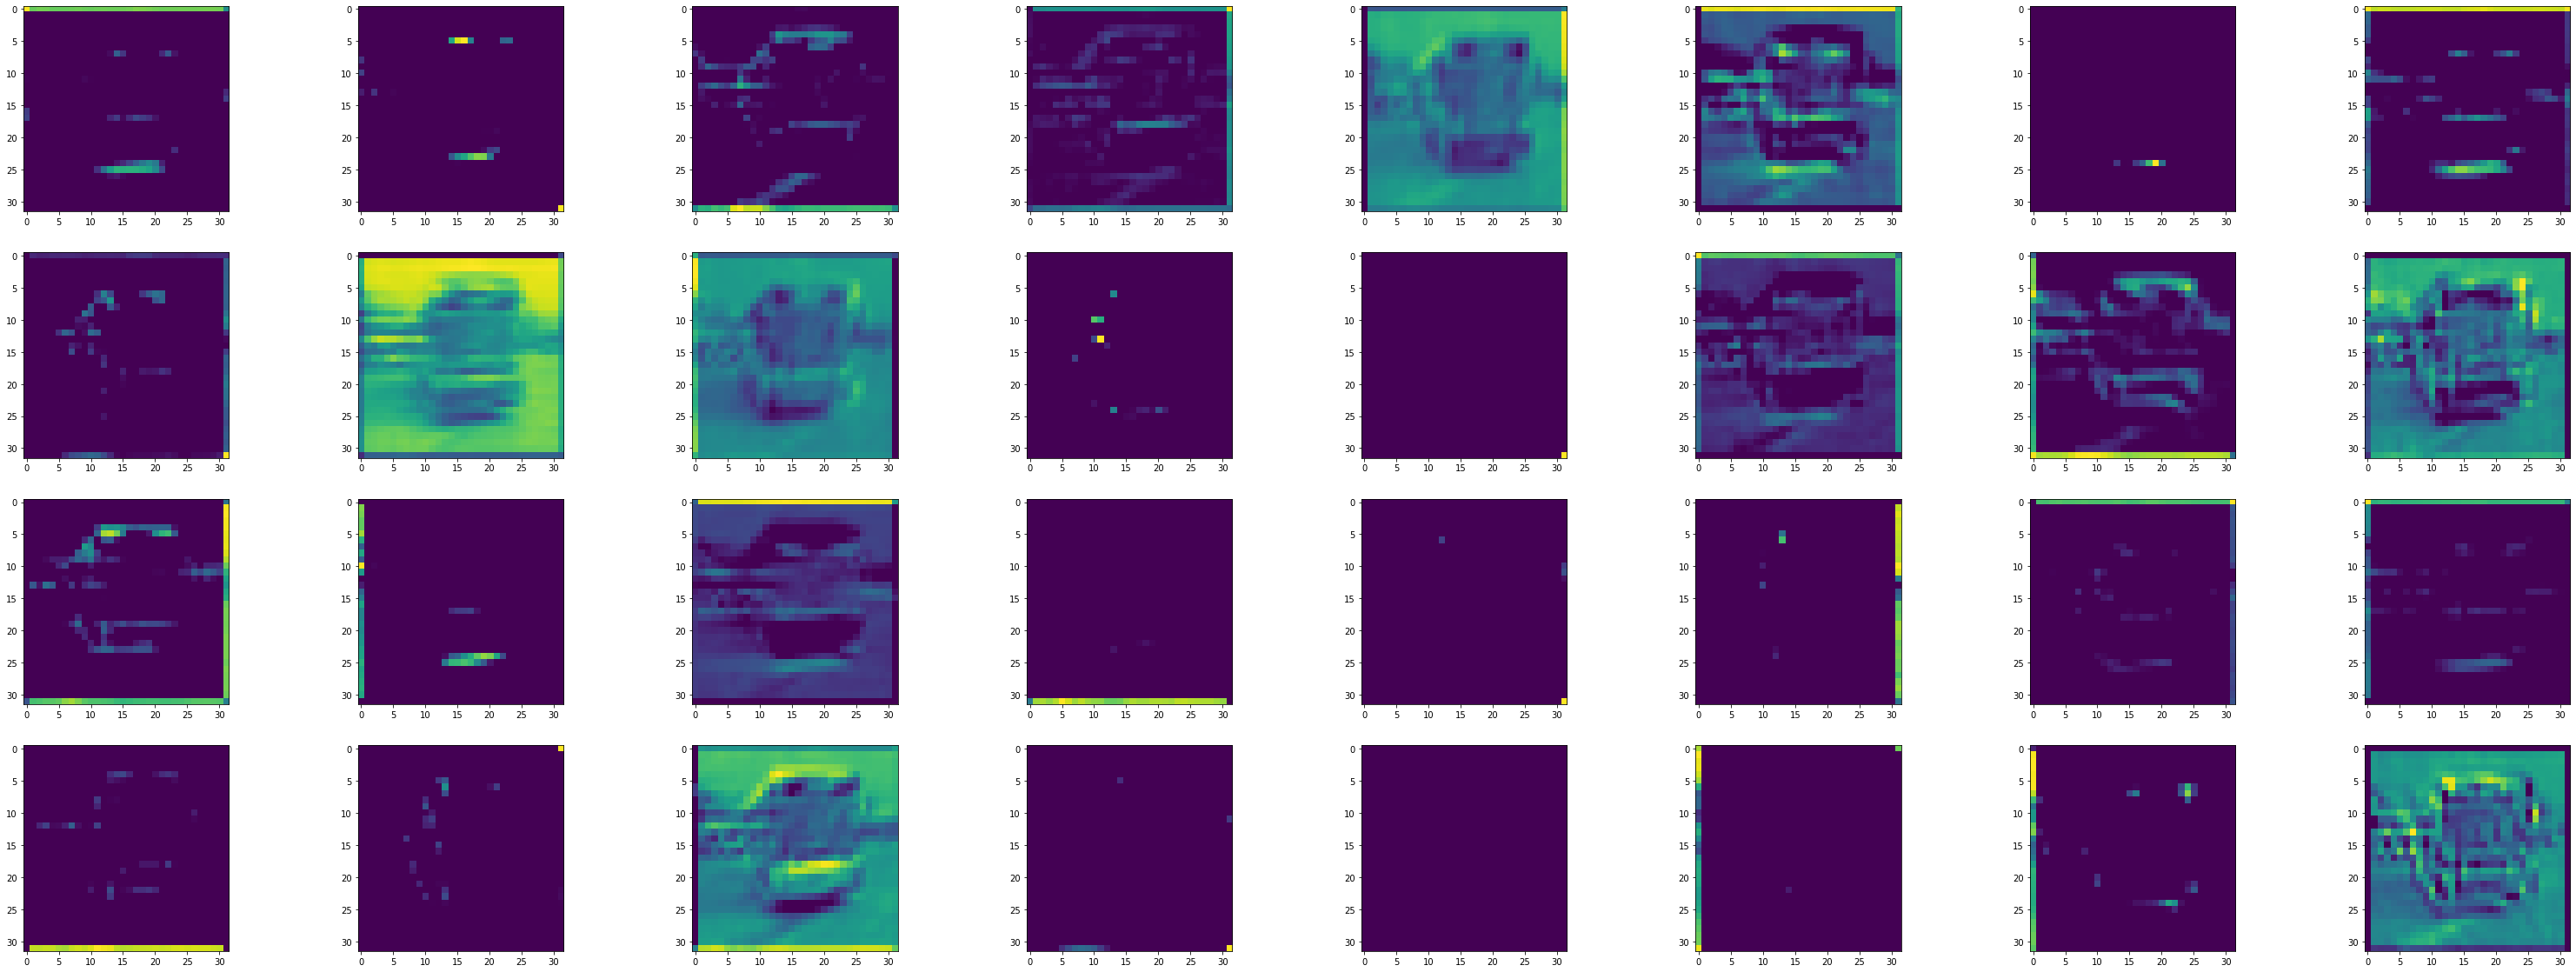

In [9]:
display_activation(model, 8, 4, 0)
print("Conv2D avec un kernel à 3")

In [10]:
model = Sequential()

model.add(Conv2D(32, kernel_size=5, activation='relu', padding='same', input_shape=(32,32,3))) ### La taille du kernel définit la précision de la convolution et influe sur la taille de l'image en sortie

### Fin obligatoire ###
model.add(Flatten())
model.add(Dense(2, activation='softmax')) ### Le paramètre dans cette fonction Dense doit être égal au nombre de catégories recherchées

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

training = model.fit_generator(train_generator, epochs=10, validation_data=validation_generator, shuffle=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 65538     
Total params: 67,970
Trainable params: 67,970
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
8/8 [==============================] - 1s 73ms/step - loss: 248.3324 - accuracy: 0.5140 - val_loss: 30.6765 - val_accuracy: 0.6900
Epoch 2/10
8/8 [==============================] - 0s 53ms/step - loss: 23.1385 - accuracy: 0.6960 - val_loss: 10.7035 - val_accuracy: 0.7400
Epoch 3/10
8/8 [==============================] - 0s 56ms/step - loss: 5.1802 - accuracy: 0.7980 

Conv2D avec un kernel à 5


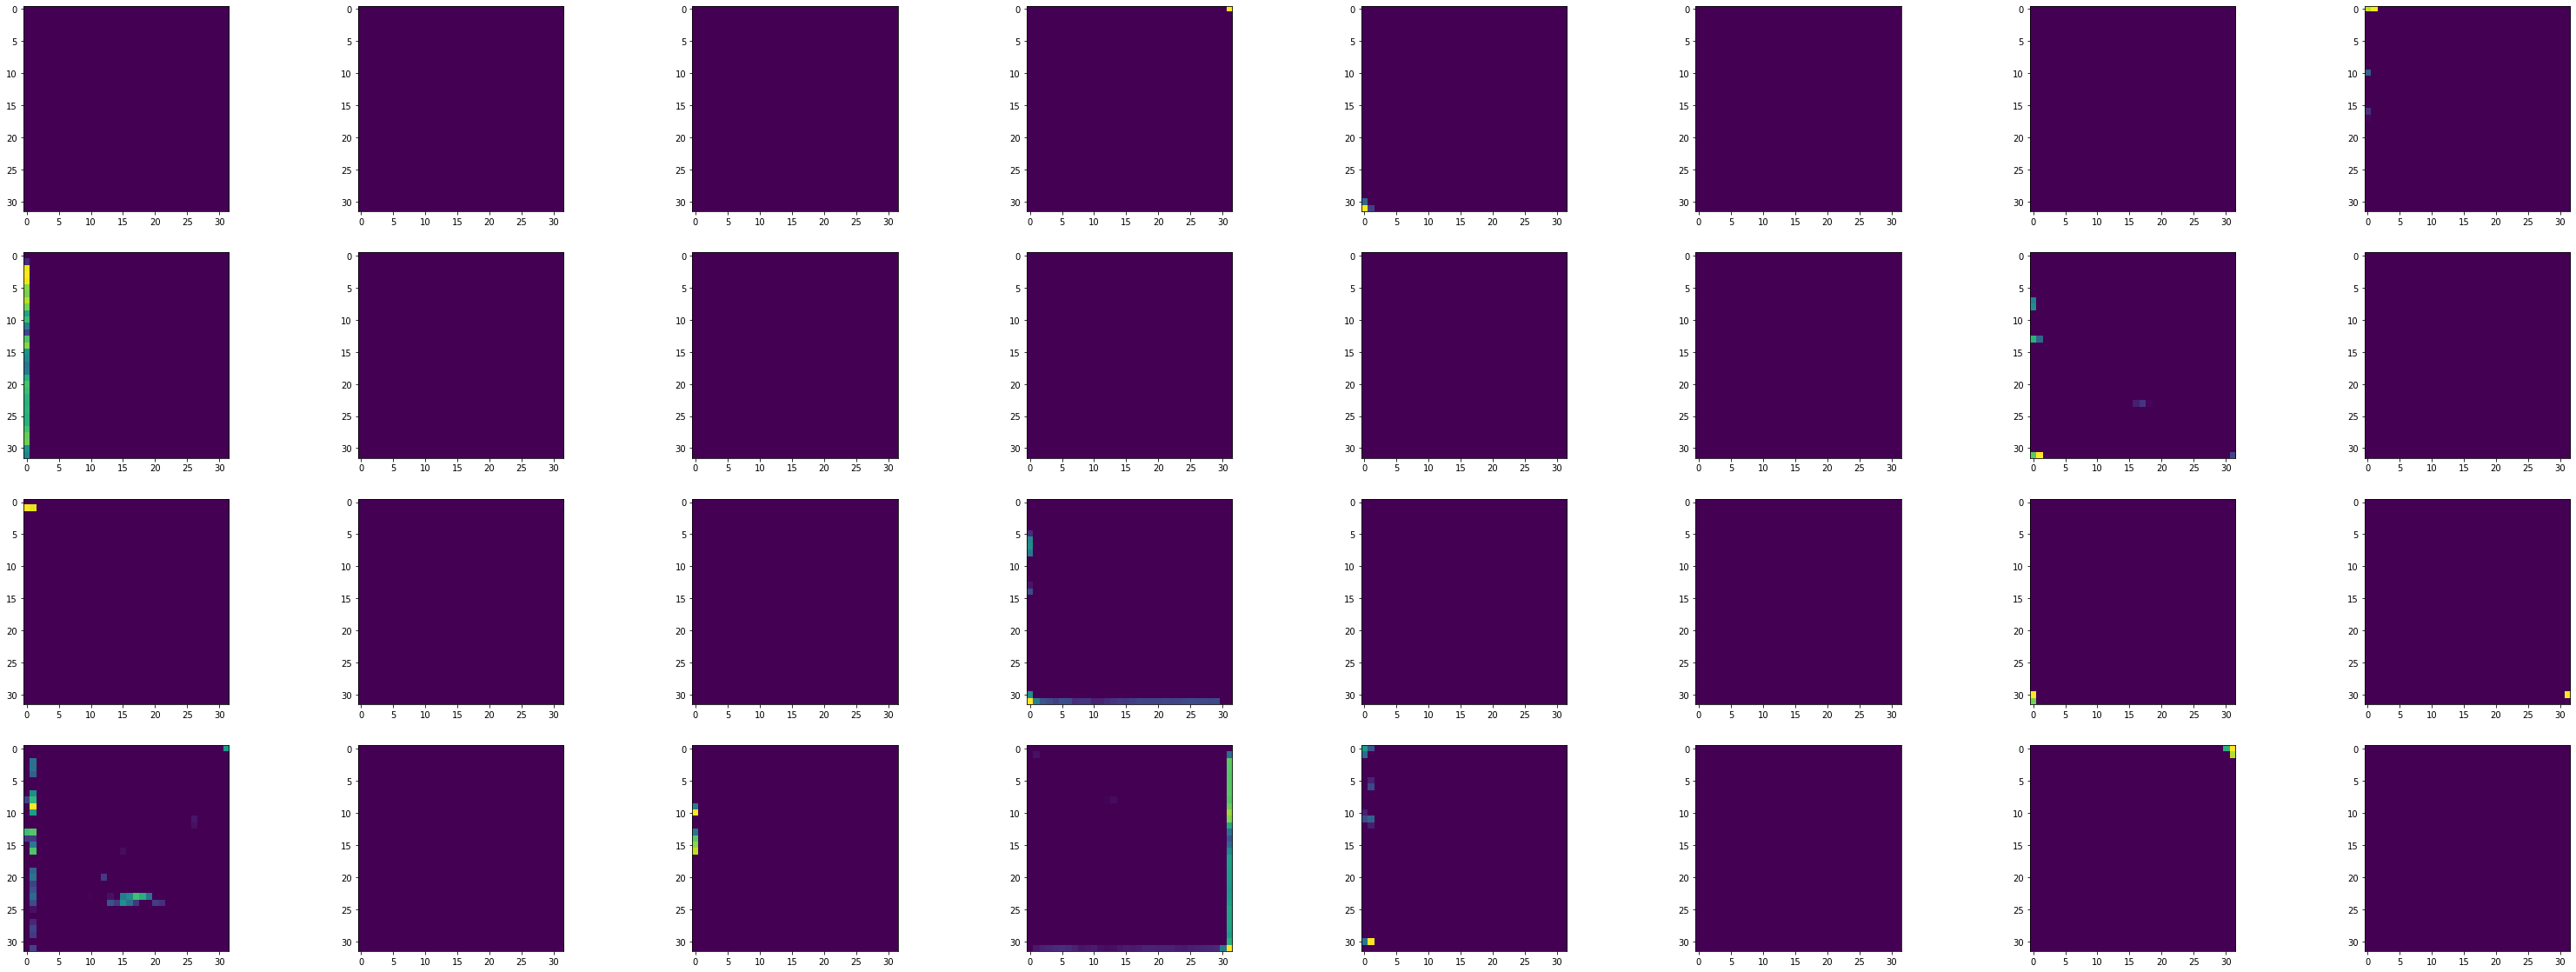

In [11]:
display_activation(model, 8, 4, 0)
print("Conv2D avec un kernel à 5")

## Conclusion

Sur notre image de dimensions 32x32, une convolution avec un kernel à 5 est trop aggressive. Nous retiendront donc une convolution avec un kernal à 3 pour la suite.

# Pooling (Max et Average)

Le pooling sert à "exagérer" l'image, pour se faire nous allons parcourir l'image avec un rectangle dont nous allons choisir la taille. Plus ce rectangle sera grand, plus la taille de l'image sera réduite.

__ATTENTION__ : ce dernier ne génère aucun paramètre et est donc inutile sans convolution. Dans les exemples suivants, nous allons simplement étudier son effet sur l'image.

__ATTENTION 2__ : Il est possible de déformer l'image avec le pooling si les proportions du carré parcourant l'image ne sont pas les mêmes que celles de l'image. Nos images étant des carrés de 32x32, nous devons garder un carré pour parcourir l'image.

In [12]:
model = Sequential()

model.add(Dense(32, activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=(2, 2))) ### Le MaxPooling ressort la valeur la plus haute présente dans le rectangle parcourant l'image

### Fin obligatoire ###
model.add(Flatten())
model.add(Dense(2, activation='softmax')) ### Le paramètre dans cette fonction Dense doit être égal au nombre de catégories recherchées

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

training = model.fit_generator(train_generator, epochs=10, validation_data=validation_generator, shuffle=False)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 16386     
Total params: 16,514
Trainable params: 16,514
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
8/8 [==============================] - 1s 72ms/step - loss: 53.7564 - accuracy: 0.5860 - val_loss: 32.1300 - val_accuracy: 0.6600
Epoch 2/10
8/8 [==============================] - 0s 52ms/step - loss: 23.9775 - accuracy: 0.7700 - val_los

MaxPooling


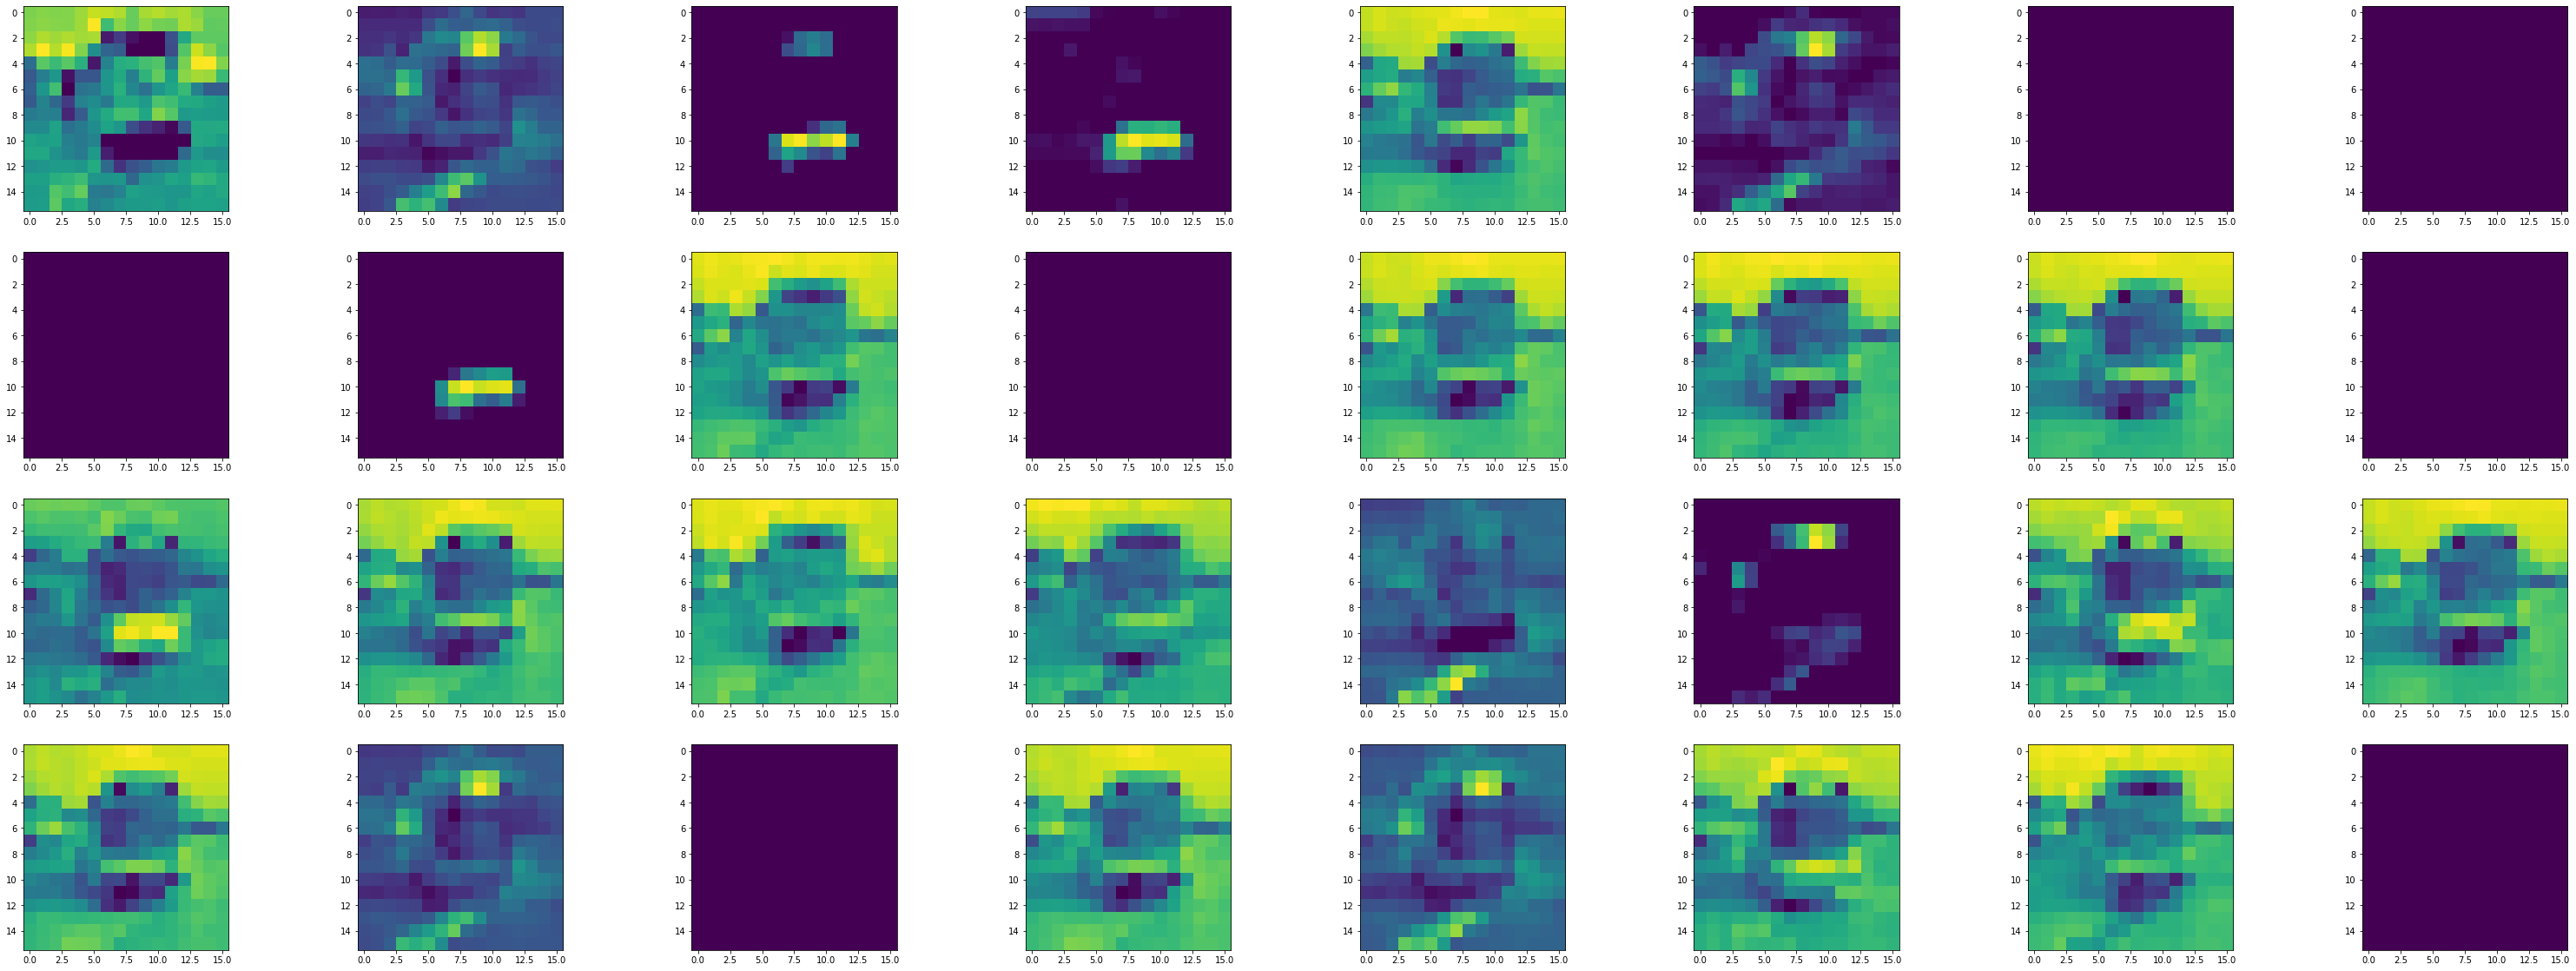

In [13]:
display_activation(model, 8, 4, 1)
print("MaxPooling")

In [14]:
model = Sequential()

model.add(Dense(32, activation='relu', input_shape=(32,32,3)))
model.add(AveragePooling2D(pool_size=(2, 2))) ### Le MaxPooling ressort la valeur moyenne des pixels présents dans le rectangle parcourant l'image

### Fin obligatoire ###
model.add(Flatten())
model.add(Dense(2, activation='softmax')) ### Le paramètre dans cette fonction Dense doit être égal au nombre de catégories recherchées

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

training = model.fit_generator(train_generator, epochs=10, validation_data=validation_generator, shuffle=False)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32, 32, 32)        128       
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 16386     
Total params: 16,514
Trainable params: 16,514
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
8/8 [==============================] - 1s 68ms/step - loss: 49.8414 - accuracy: 0.5860 - val_loss: 12.2471 - val_accuracy: 0.6800
Epoch 2/10
8/8 [==============================] - 0s 52ms/step - loss: 11.9612 - accuracy: 0.7460 - val_los

AveragePooling


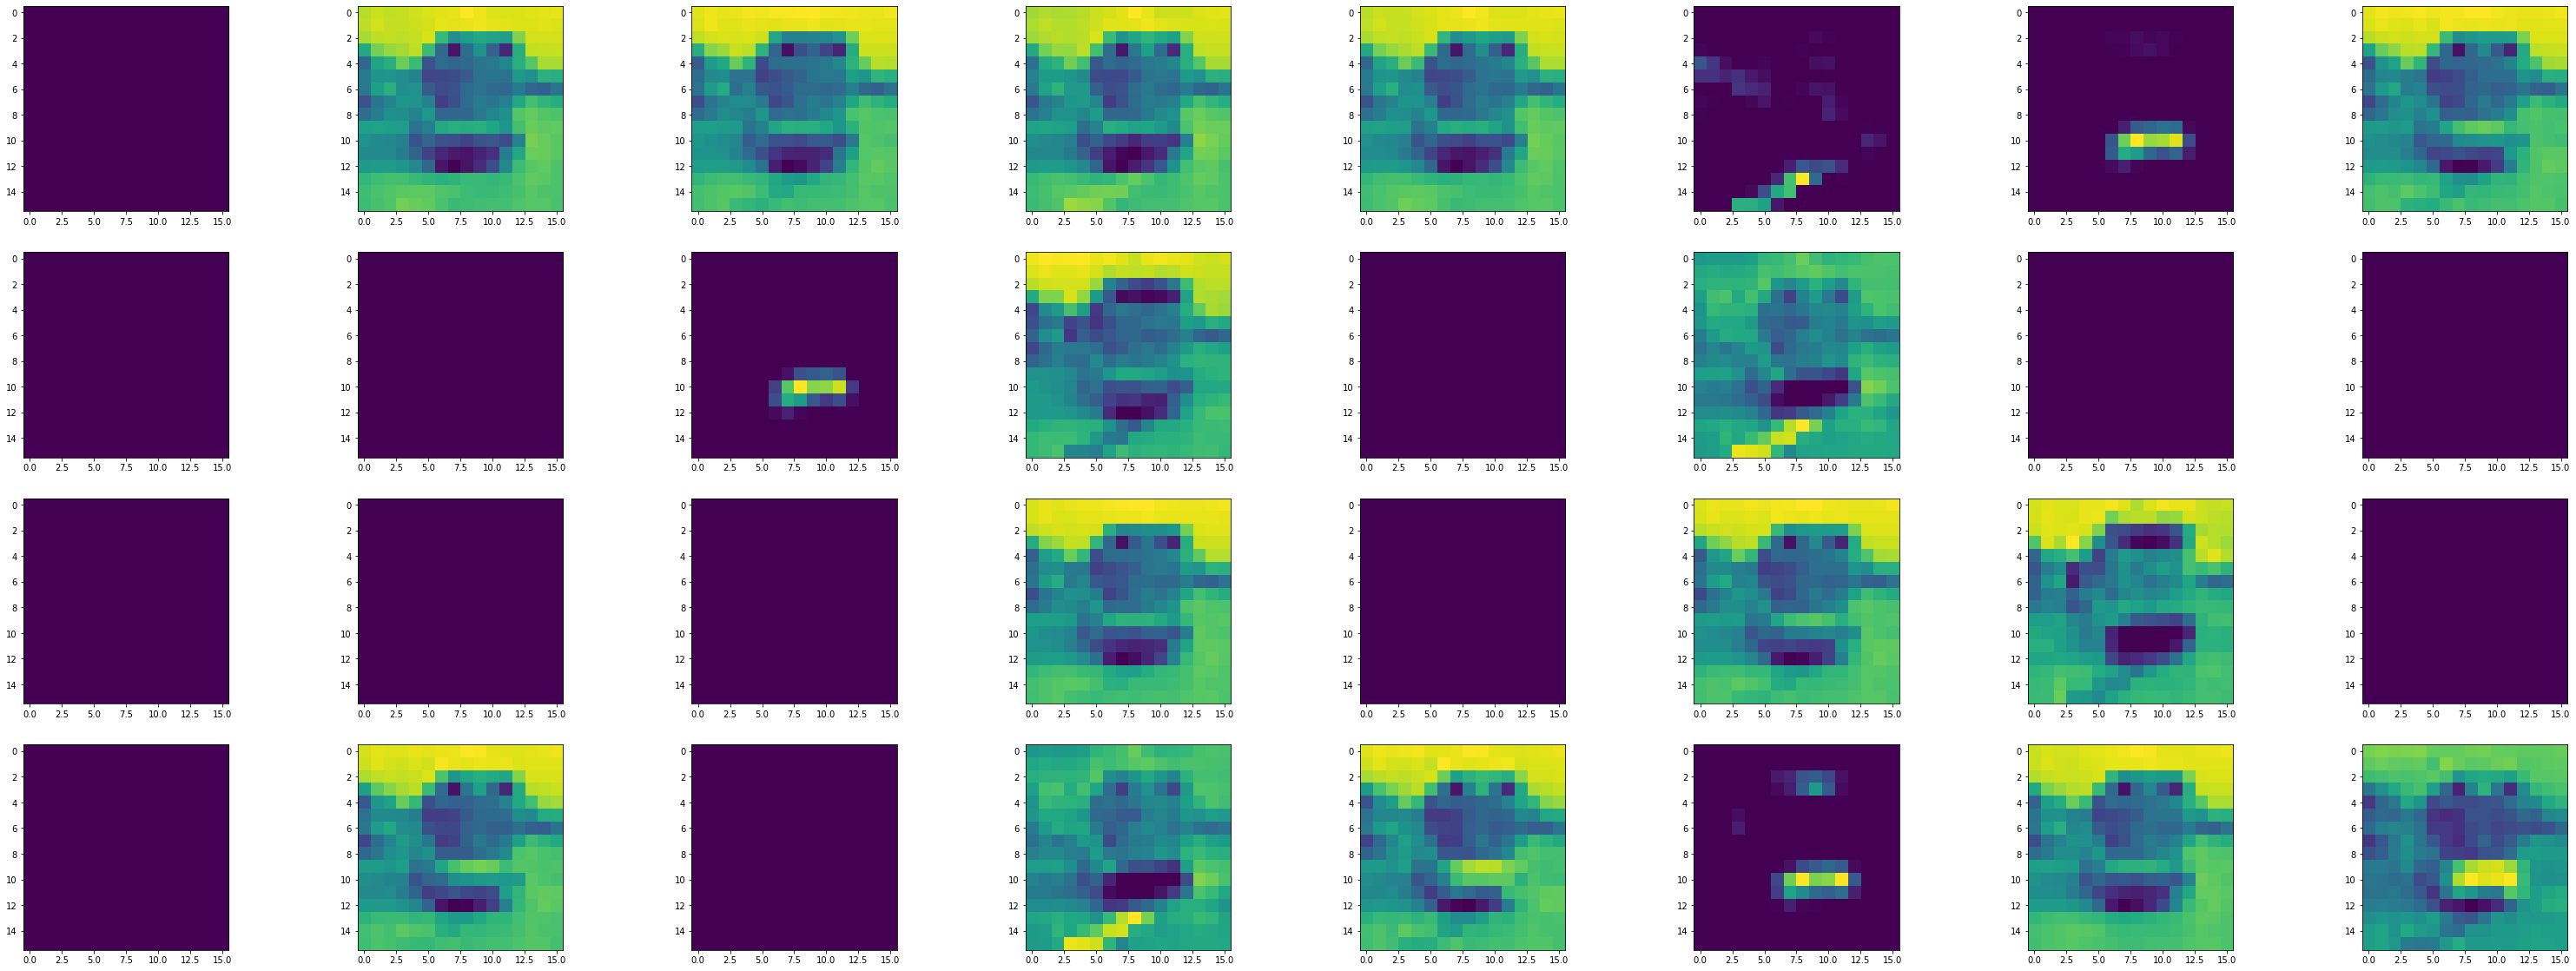

In [15]:
display_activation(model, 8, 4, 1)
print("AveragePooling")

In [16]:
model = Sequential()

model.add(Dense(32, activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=(3, 2))) ### Le MaxPooling ressort la valeur la plus haute présente dans le rectangle parcourant l'image

### Fin obligatoire ###
model.add(Flatten())
model.add(Dense(2, activation='softmax')) ### Le paramètre dans cette fonction Dense doit être égal au nombre de catégories recherchées

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

training = model.fit_generator(train_generator, epochs=10, validation_data=validation_generator, shuffle=False)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 16, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5120)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 10242     
Total params: 10,370
Trainable params: 10,370
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
8/8 [==============================] - 1s 69ms/step - loss: 36.3339 - accuracy: 0.5640 - val_loss: 3.7702 - val_accuracy: 0.8300
Epoch 2/10
8/8 [==============================] - 0s 53ms/step - loss: 11.4958 - accuracy: 0.7740 - val_loss

MaxPooling en altérant le ratio de l'image


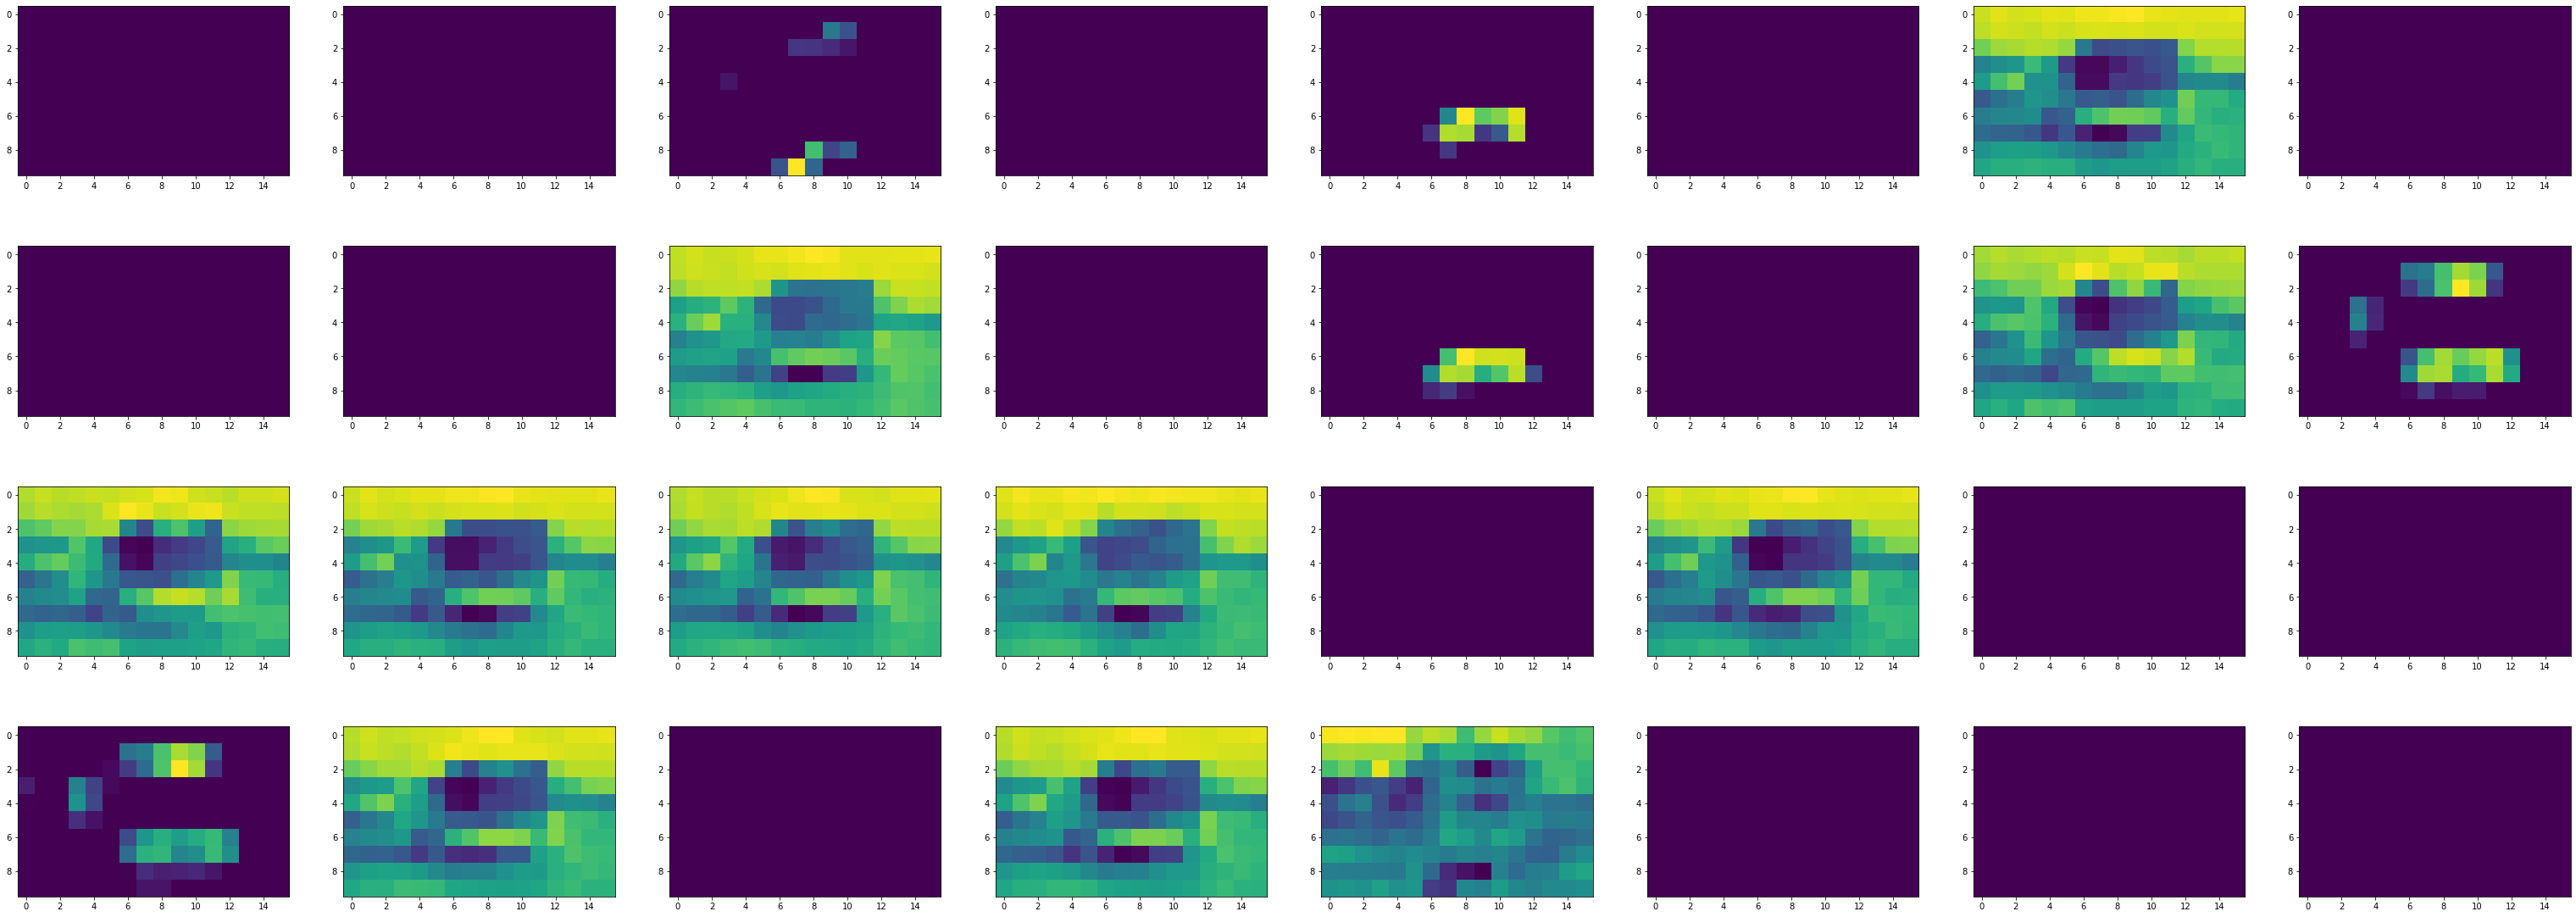

In [17]:
display_activation(model, 8, 4, 1)
print("MaxPooling en altérant le ratio de l'image")

## Conclusion

Il est impératif d'utiliser un Pooling "carré" pour conserver les proportions de l'image.
Après plusieurs tests, le MaxPooling a donné de meilleurs résultats et sera donc conservé pour la suite.

# Droupout

Cette couche est difficile à observer. Son rôle est d'éteindre une partie des neuronnes (choisies au hasard) afin d'éviter le surapprentissage

# Dense

Comme le Dropout, cette couche n'est pas facilement observable. Elle "ajoute des couches à l'image", afin de retrouver plus facilement les features.

# Tests de modèles

Dans cette partie, nous allons tester différents modèles et évaluer leur efficacité. Le nombre d'epoch sera fortement augmenté mais le modèle "s'arrêtera tout seul", grâce au module EarlyStopping, pour éviter le surapprentissage.

Premier test : nous allons tester un modèle composé deux deux convolutions et d'un pooling

In [26]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(32,32,3))) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))

#Fin obligatoire
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es_callback = EarlyStopping(monitor='val_loss', patience=3)

training = model.fit_generator(train_generator, epochs=50, callbacks=[es_callback], validation_data=validation_generator, shuffle=False)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dense_15 (Dense)             (None, 16, 16, 64)        2112      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
flatten_8 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


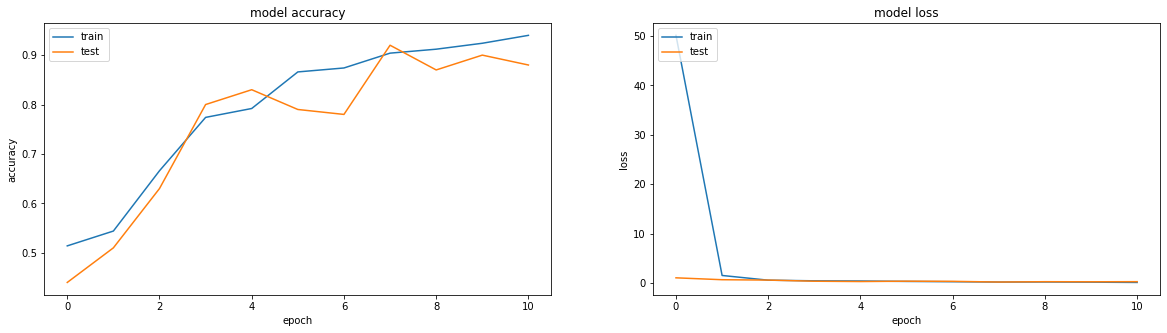

In [27]:
print_model_history(training)

Sur ce modèle, on peut voir que la précision du modèle lors des tests se rapproche de celle du modèle lors de l'entrainement.
Ce modèle a un résultat satisfaisant sur nos 2 catégories mais le résultat est beaucoup moins bon lorsque l'on utilise les 100 catégories du dataset.

Deuxième test : Ajout troisième couche de convolution et d'une deuxième couche de pooling

In [28]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(32,32,3))) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))

#Fin obligatoire
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es_callback = EarlyStopping(monitor='val_loss', patience=3)

training = model.fit_generator(train_generator, epochs=50, callbacks=[es_callback], validation_data=validation_generator, shuffle=False)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dense_17 (Dense)             (None, 16, 16, 64)        2112      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dense_18 (Dense)             (None, 8, 8, 128)        

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


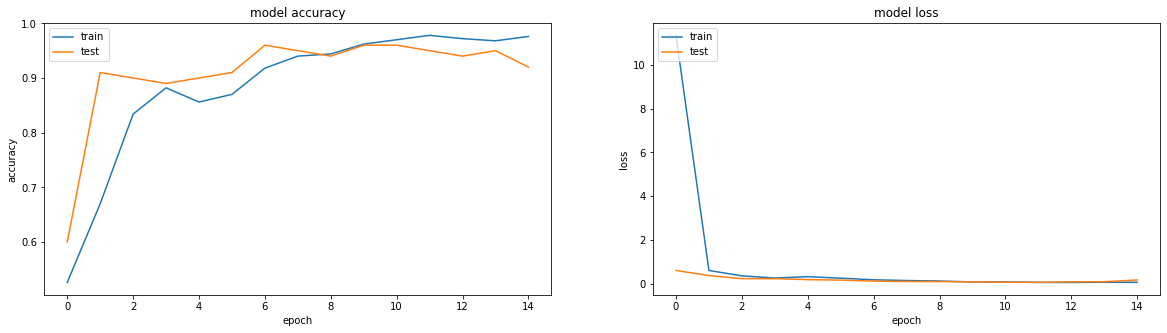

In [29]:
print_model_history(training)

Avec ce modèle,le modèle apprends beaucoup plus vite et obtient un très bon résultat très tot dans l'apprentissage et un résultat assez satisfaisant sur les 100 catégories.Nous avons donc décidé de garder ce dernier. 